In [1]:
import timeit
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

from skimage.filters import gaussian, threshold_otsu
import pyclesperanto_prototype as clesp_p
from pyclesperanto import Clesperanto

pyclic = Clesperanto()
pyclic.set_wait_for_kernel_to_finish()

clesp_p.select_device()
clesp_p.set_wait_for_kernel_finish()

In [2]:
def benchmark_clesp_p_size(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 100) * 10
    benchmark_data = []

    for size in sizes:
        # make new data
        image = np.random.rand(size, size)
        gpu_image = clesp_p.push(image)
        gpu_result = clesp_p.create(image.shape)
        # bind target function to given image
        partial_function = partial(target_function, gpu_image, gpu_result)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=10)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=20)
        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

def benchmark_pyclic_size(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 100) * 10
    benchmark_data = []

    for size in sizes:
        # make new data
        image = np.random.rand(size, size)
        gpu_image = pyclic.push(image)
        gpu_result = pyclic.create(image.shape)
        # bind target function to given image
        partial_function = partial(target_function, gpu_image, gpu_result)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=10)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=20)
        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

def benchmark_skimage_size(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 100) * 10
    benchmark_data = []

    for size in sizes:
        # make new data
        image = np.random.rand(size, size)

        # bind target function to given image
        partial_function = partial(target_function, image)
        # warmup       
        warm_up_time_in_s = timeit.timeit(partial_function, number=10)
        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=20)
        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)


## Benchmark : otsu

In [3]:
def pyclic_threshold_otsu(gpu_image, gpu_result):
    pyclic.threshold_otsu(input_image=gpu_image, output_image=gpu_result)

def clesp_p_threshold_otsu(gpu_image, gpu_result):
    clesp_p.threshold_otsu(source=gpu_image, destination=gpu_result)
    
def skimage_threshold_otsu(image):
    res = image > threshold_otsu(image)

In [4]:
time_pyclic_size = benchmark_pyclic_size(pyclic_threshold_otsu)
time_clesp_p_size = benchmark_clesp_p_size(clesp_p_threshold_otsu)
time_skimage_size = benchmark_skimage_size(skimage_threshold_otsu)

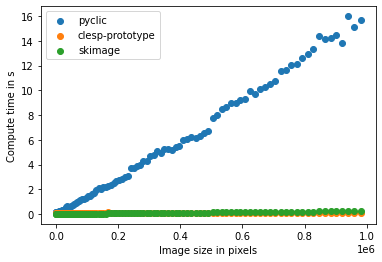

In [5]:
plt.scatter(time_pyclic_size[:,0] ** 2, time_pyclic_size[:,1])
plt.scatter(time_clesp_p_size[:,0] ** 2, time_clesp_p_size[:,1])
plt.scatter(time_skimage_size[:,0] ** 2, time_skimage_size[:,1])

plt.legend(["pyclic", "clesp-prototype", "skimage"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()